In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# **Initializing objects:**

In [2]:
True & False

False

In [17]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  365
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


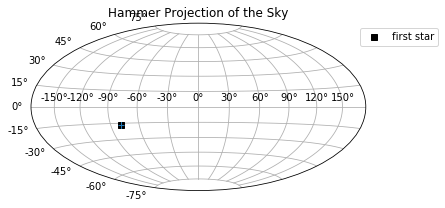

In [18]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# **Scan**

In [19]:
1/24*3

0.125

In [33]:
scanSirio.scan(gaia, sirio, ti=t_init, tf=t_end)
#print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
#print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
#print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)


Starting scan with time from 0 to 365 days
time for constraints t: 41.58333333333333 is 0.0007946491241455078
time for t: 41.58333333333333   : 0.001210927963256836
time for constraints t: 89.33333333333333 is 0.0009615421295166016
time for t: 89.33333333333333   : 0.0012054443359375
time for constraints t: 214.91666666666666 is 0.0008831024169921875
time for t: 214.91666666666666   : 0.0010533332824707031
time for constraints t: 267.25 is 0.000888824462890625
time for t: 267.25   : 0.0010762214660644531
time for constraints t: 294.25 is 0.0009157657623291016
time for t: 294.25   : 0.002040863037109375
time for constraints t: 352.5833333333333 is 0.0009217262268066406
time for t: 352.5833333333333   : 0.0011622905731201172
Total measured time: 3.977304458618164
How many observation time?  6


In [34]:
scanSirio.compute_angles_eta_zeta(gaia, sirio)
scanSirio.eta_scanned

[2.597926206420947e-14,
 -3.7225704176161166e-14,
 -2.164937697140836e-14,
 -3.1147306974356593e-13,
 -1.0275142230141458e-13,
 -1.5526693533285624e-13]

In [35]:
print(scanSirio.scanner_error())
print(np.mean(scanSirio.zeta_scanned))

-1.0039787441019946e-13
0.001017428765234517


In [36]:
angle = np.radians(270)
angle % (2*np.pi)

4.71238898038469

In [37]:
gaia.wz/24*360/2/np.pi

59.99999999999999

In [38]:
# day/rev
1/24*6

0.25

In [39]:
a = gaia.wz/(2*np.pi)
1/a

0.25

# **Plots:**

In [40]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [41]:


def vector_error(t):
    u_lmn_unit = source.unit_topocentric_function(sat, t)
    vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
    vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
    return vector_error_xyz

def rad_to_mas(angle):
    """:input: angle in rad
       :output: angle in mas"""
    return angle*u.rad.to(u.mas)


In [42]:
print(scanSirio.obs_times)

[41.600533602619784, 89.37732242253135, 214.94573220091394, 267.30952691499346, 294.30022850139204, 352.6603800705228]


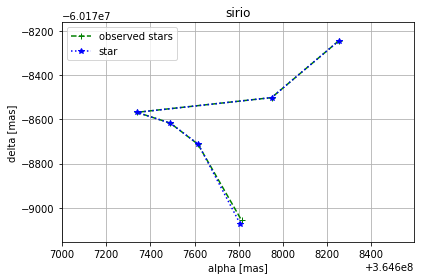

6

In [43]:


alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha, delta, radius = ft.vector_to_polar(satellite.func_x_axis_lmn(t))
    alphas_obs.append( rad_to_mas(alpha % (2 * np.pi)))
    deltas_obs.append( rad_to_mas(delta))
    # radius_obs.append(radius)
    # source.set_time(t)
    # star_alphas.append(source.alpha)
    # star_deltas.append(source.delta)
    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)

    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    v_error = vector_error(t)

    vectorz1 = xaxis + np.radians(0.5) * zaxis
    vectorz2 = xaxis - np.radians(0.5) * zaxis

    z_alpha_1, z_delta_1, _ = ft.vector_to_polar(vectorz1)
    z_alpha_2, z_delta_2, _ = ft.vector_to_polar(vectorz2)

    z_alphas.append([rad_to_mas(z_alpha_1), rad_to_mas(z_alpha_2)])
    z_deltas.append([rad_to_mas(z_delta_1), rad_to_mas(z_delta_2)])
    
    vectorz1 = xaxis + v_error[2]*zaxis

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
    

for alphas, deltas in angle_list:
    # alphas*u.rad.to(u.mas)
    # deltas*u.rad.to(u.mas)
    pass

# For each couple of ([alpha1,alpha2],[delta1,delta2])
for alpha_delta in zip(z_alphas, z_deltas):
    # plt.plot(alpha_delta[0], alpha_delta[1], 'yo-')
    pass
# plt.plot(alphas_obs, deltas_obs, 'ro--', label='observations')  # plot observation as re dots

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
len(star_alphas)

In [44]:
# scanSirio.reset(True)

In [45]:
scanSirio.scanner_error()

-1.0039787441019946e-13

# **2- Combine with solver:**

In [46]:
my_sirio = Calc_source(scanSirio.obs_times, source=sirio) 

print('real:', my_sirio.s_params)
my_sirio.set_params(my_sirio.s_params + my_sirio.s_params*1e-10)
print('noised:', my_sirio.s_params)
Solver = Agis(gaia, [my_sirio], [sirio], updating='source')

real: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]
noised: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]


In [47]:
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.02 / 1
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 10
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

my_sirio = Calc_source('sirio', scanSirio.obs_times, s, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio], updating='source')

In [48]:
Solver.iterate(100)

***** Iteration: 1 *****
Error after iteration: 7.711701596798925e-05
***** Iteration: 2 *****
Error after iteration: 2.0078525085698223e-06
***** Iteration: 3 *****
Error after iteration: 4.617752949406956e-07
***** Iteration: 4 *****
Error after iteration: 3.676766580380438e-05
***** Iteration: 5 *****
Error after iteration: 0.00033132275407821913
***** Iteration: 6 *****
Error after iteration: 84.49686725464468
***** Iteration: 7 *****
Error after iteration: 11.796992933578164
***** Iteration: 8 *****
Error after iteration: 71.62491096190254
***** Iteration: 9 *****
Error after iteration: 65.71465836444699
***** Iteration: 10 *****
Error after iteration: 108.27385107742354
***** Iteration: 11 *****
Error after iteration: 74.90533403612714
***** Iteration: 12 *****
Error after iteration: 30.2691353212443
***** Iteration: 13 *****
Error after iteration: 17.022519788571636
***** Iteration: 14 *****
Error after iteration: 16.218910573701063
***** Iteration: 15 *****
Error after iteratio

In [49]:
gaia.wz

25.132741228718345

In [ ]:
optimize.brentq(f=eta_error, a=t, b=t+time_step, args=(